In [1]:
import numpy as np
import pickle
import os
import pyimfit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import angular_separation
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import logging
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from astropy.visualization import simple_norm
from photutils.aperture import EllipticalAperture
from photutils.isophote import build_ellipse_model,Ellipse, EllipseGeometry
import pickle
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
warnings.filterwarnings('ignore')

medium_font_size = 12
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size

outpath = os.path.expandvars("~/agn-result/box/")


In [2]:
def get_size(filename):
    """get image size for data sorting"""
    return int(filename.split('_')[1].split('.')[0])


def find_sky(image, plothist=False):
    bgr = plt.hist(image.flatten(),bins=np.arange(np.min(image),20))
    plt.close()
    max_ind = np.where(bgr[0]==np.max(bgr[0]))[0][0]
    sky = (bgr[1][max_ind]+bgr[1][max_ind+1])/2
    if plothist:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].hist(image.flatten(),bins=np.arange(np.min(image),np.max(image)))
        ax[1].hist(image.flatten(),bins=np.arange(np.min(image),20))
        [ax[i].set_title(['Whole intensity range',f'sky level: {float(sky):.4f}'][i]) for i in range(2)]
        [ax[i].set_xlabel('intensity') for i in range(2)]
        ax[0].set_ylabel('number of pixels')
        ax[1].axvline(x=sky)
    return sky


def get_data(on):
    """get images, sizes, and sky levels"""
    allfile = [f for f in os.listdir("../../agn-result/box/boxsize_"+on) if f[0]=="J"]
    files = sorted(allfile, key=get_size)
    size = [int((f.split(".")[0]).split("_")[1]) for f in files]
    images= [fits.getdata("../../agn-result/box/boxsize_"+on+"/"+f) for f in files]
    # find sky level
    skies = np.array([find_sky(image) for image in images])
    return size,images,skies


def make_peak_tbl(image,intens,agnsize=35):
    """mask out agn and find peaks"""
    s = image.shape[0]
    midf = int(s//2)
    # mask out central agn
    peak_mask = np.zeros((s,s))
    peak_mask[midf-agnsize:midf+agnsize,midf-agnsize:midf+agnsize] = 1
    # convert to boolean
    peak_mask = peak_mask==1
    # detect peaks
    peak_tbl = find_peaks(image,threshold=intens,mask=peak_mask)
    return peak_tbl


def plot_peaks(image,peak_tbl):
    """circular aperture plot of peaks for 1 image"""
    positions = np.transpose((peak_tbl['x_peak'], peak_tbl['y_peak']))
    apertures = CircularAperture(positions, r=4.0)
    plt.imshow(image,norm='symlog')
    apertures.plot(color="w",lw=0.5);


def make_mask(image,pos,aper_radius,pa=180):
    """make a mask provided position and aperture radius"""
    aper0 = EllipticalAperture(pos,aper_radius,aper_radius,pa)
    aper_mask0 = aper0.to_mask()
    mask0 = aper_mask0.to_image(image.shape)
    return mask0

def mask_image(image,peak_tbl,rad):
    """create mask and masked images"""
    mask=[]
    # make masks
    for i in range(len(peak_tbl)):
        mask.append(make_mask(image,pos = [peak_tbl[i]['x_peak'],peak_tbl[i]['y_peak']],aper_radius=rad))
    # sum all masks
    mask = np.sum(mask,axis=0)
    # make masked image
    masked_im = np.where(mask==0,image,0)
    return masked_im


def plot_masked_image(image,masked_image):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image,norm='symlog')
    ax[1].imshow(masked_image,norm='symlog')
    ax[0].set_title(image.shape)


In [3]:
def profile_1D(semiA,image,PA=180,force_exp=True):
    """make 1D elliptical profiles"""
    # create guess ellipse
    pos0 = image.shape[0]//2
    geometry = EllipseGeometry(x0=pos0, y0=pos0, sma=semiA, eps=0.5,
                               pa=PA * np.pi / 180.0)
    # load image and geometry
    ellipse = Ellipse(image, geometry)
    # do isophote fit
    if force_exp:
        isolist = ellipse.fit_image(maxsma=np.round(image.shape[0]*3/5))
    else:
        isolist = ellipse.fit_image()
    return isolist


def make_isophotes(masked_images):
    """make force expand and normal isophotes for images"""
    isolists_force_exp = []
    isolists_norm = []
    for i in range(len(size)):
        iso_exp = profile_1D(semiA=30,image=masked_images[i],PA=180,force_exp=True)
        iso_norm = profile_1D(semiA=30,image=masked_images[i],PA=180,force_exp=False)
        isolists_force_exp.append(iso_exp)
        isolists_norm.append(iso_norm)
    return isolists_force_exp, isolists_norm


def plot_isophotes(ax,isolist):
    """plot aperatures on image"""
    for sma in isolist.sma:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        ax.plot(x, y, color='white',linewidth="0.5")


def find_best_size(skies, itens, size):
    # find the lowest difference between sky level and outmost intens
    diff = np.abs((skies-itens)/itens)*100
    min_val = np.min(diff)
     # make sure %diff is < 20%   
    if min_val <= 20:
        min_ind = np.where(diff==min_val)[0][0]
        min_size = size[min_ind]
        print(f"Best size: {min_size}, sky level: {skies[min_ind]:.3f}, outmost intensity: {itens[min_ind]:.3f}, % diff: {diff[min_ind]:.3f}")
    else:
        print("No good size found")


def save_pkl(filename):
    datasave={}
    datasave['iso-exp'] = isolists_force_exp
    datasave['iso-norm'] = iso_norm
    datasave['masked-ims'] = masked_images

    with open(os.path.expanduser(outpath+filename), "wb") as f:
        pickle.dump(datasave,f)

In [4]:
size,images,skies = get_data("J0813+0905")
print(size[0],size[-1],len(size))

80 700 42


In [7]:
# make masked images
masked_images= []
peak_tbls=[]
for i in range(len(size)):
    peak_tbl = make_peak_tbl(images[i],intens=7)
    masked_image = mask_image(images[i],peak_tbl,rad=23)
    masked_images.append(masked_image)
    peak_tbls.append(peak_tbl)

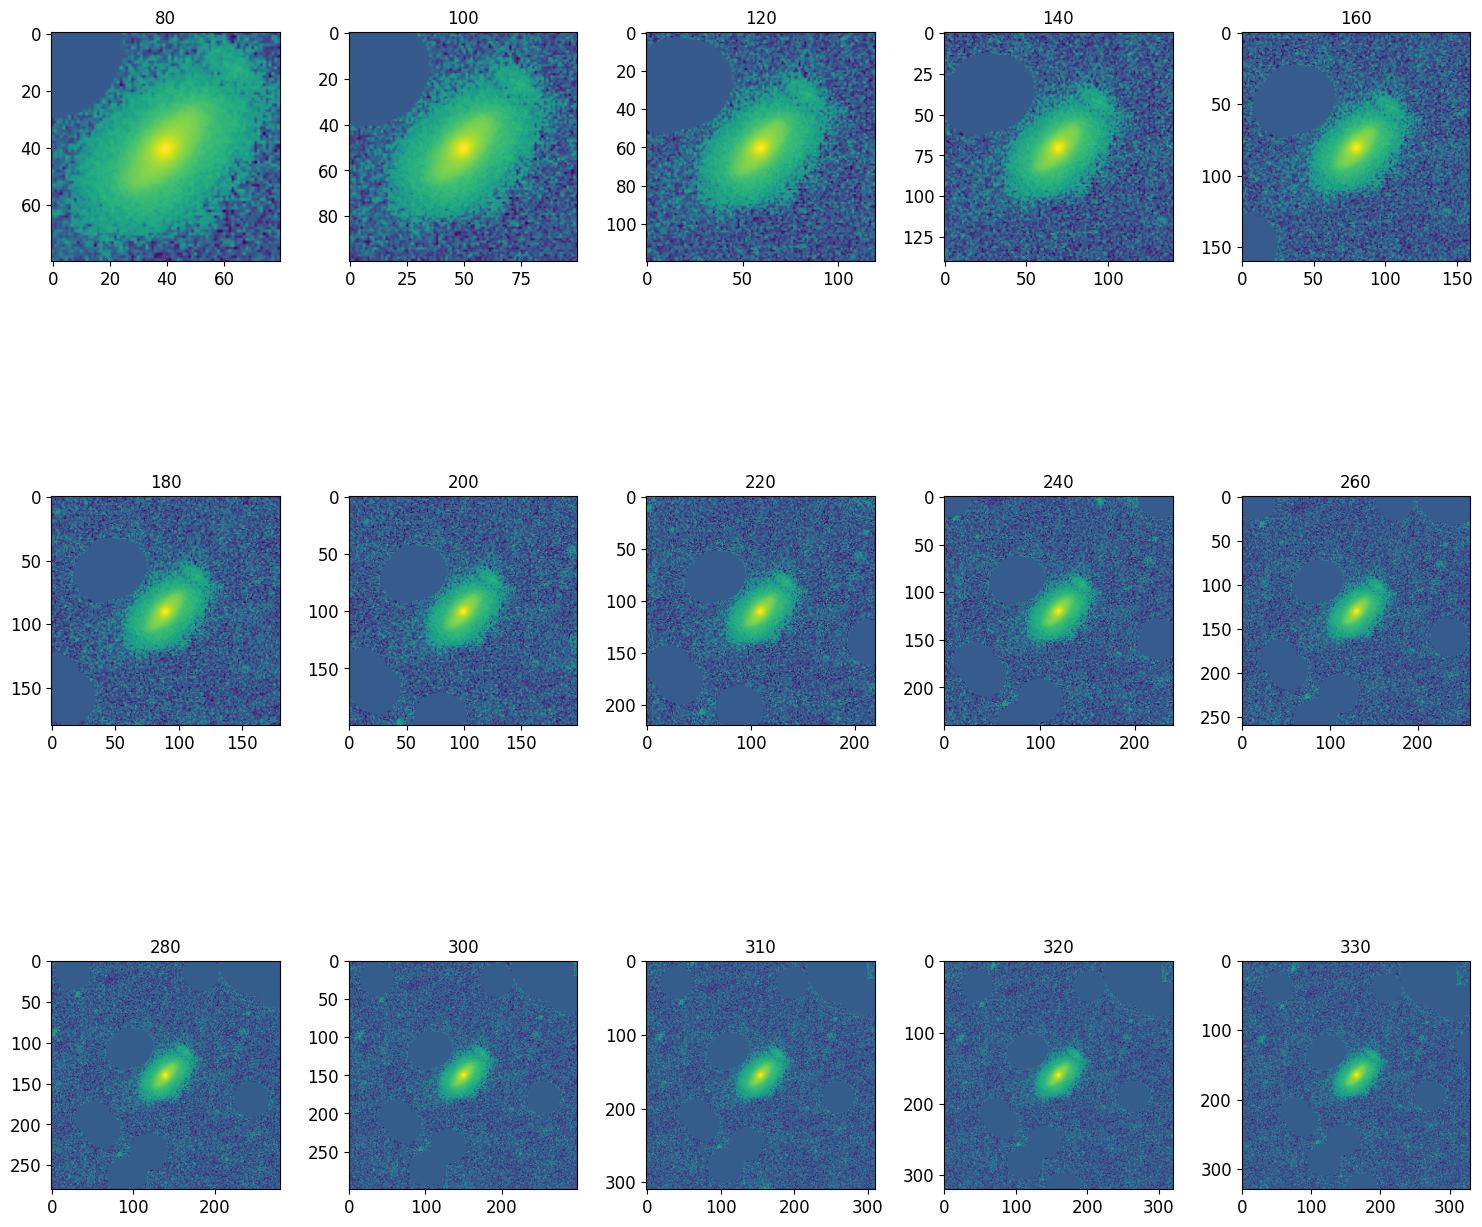

In [68]:
fig,ax = plt.subplots(3,5,figsize=(15,15))
ax = ax.ravel()
[ax[i].imshow(ims21[i],norm='symlog') for i in range(len(ax))]
[ax[i].set_title(size[i]) for i in range(len(ax))]
fig.tight_layout();
#[plot_isophotes(ax[i],masked_images[i],isolists_norm[i]) for i in range(len(ax))];

In [5]:
with open(os.path.expanduser(outpath+"J0813+0905_iso_r15.pkl"),"rb") as f:
    d15 = pickle.load(f)

with open(os.path.expanduser(outpath+"J0813+0905_iso_r21.pkl"),"rb") as f:
    d21 = pickle.load(f)

In [44]:
iso_norm15 = d15['iso-norm']
iso_exp15 = d15['iso-exp']
ims15 = d15['masked-ims']
iso_norm21 = d21['iso-norm']
iso_exp21 = d21['iso-exp']
ims21 = d21['masked-ims']

iout_norm15 = np.array([iso_norm15[i].intens[-1] for i in range(len(size))])
iout_exp15 = np.array([iso_exp15[i].intens[-1] for i in range(len(size))])
masked_sky15 = np.array([find_sky(ims15[i]) for i in range(len(size))])
diff_norm15 = np.abs(iout_norm15-masked_sky15)/np.abs(masked_sky15)*100
diff_exp15 = np.abs(iout_exp15-masked_sky15)/np.abs(masked_sky15)*100

iout_norm21 = np.array([iso_norm21[i].intens[-1] for i in range(len(size))])
iout_exp21 = np.array([iso_exp21[i].intens[-1] for i in range(len(size))])
masked_sky21 = np.array([find_sky(ims21[i]) for i in range(len(size))])
diff_norm21 = np.abs(iout_norm21 - masked_sky21) / np.abs(masked_sky21) * 100
diff_exp21 = np.abs(iout_exp21 - masked_sky21) / np.abs(masked_sky21) * 100

In [8]:
bgn=[find_sky(masked_images[i]) for i in range(len(size))]

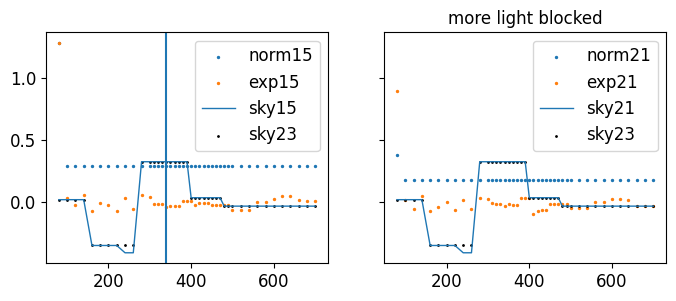

In [33]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(8,3))
[ax[i].scatter(size,iout,s=2,label=lab) for i,iout,lab in zip([0,1],[iout_norm15,iout_norm21],["norm15","norm21"])]
[ax[i].scatter(size,iout,s=2,label=lab) for i,iout,lab in zip([0,1],[iout_exp15,iout_exp21],["exp15","exp21"])]
[ax[i].plot(size,iout,lw=1,label=lab) for i,iout,lab in zip([0,1],[masked_sky15,masked_sky21],["sky15","sky21"])]
[ax[i].scatter(size,bgn,c="k",s=1,label="sky23") for i in range(2)]
[ax[i].legend() for i in range(2)]
ax[1].set_title('more light blocked')


[Text(0.5, 0, 'intensity'), Text(0.5, 0, 'intensity')]

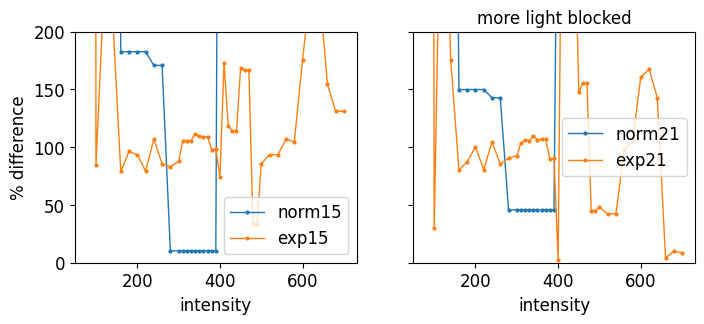

In [106]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(8,3))
[ax[i].plot(size,iout,marker="o",lw=1,markersize=2,label=lab) for i,iout,lab in zip([0,1],[diff_norm15,diff_norm21],["norm15","norm21"])]
[ax[i].plot(size,iout,marker="o",lw=1,markersize=2,label=lab) for i,iout,lab in zip([0,1],[diff_exp15,diff_exp21],["exp15","exp21"])]
[ax[i].legend() for i in range(2)]
[ax[i].set_ylim((0,200)) for i in range(2)]
ax[1].set_title('more light blocked')
ax[0].set_ylabel("% difference")
[ax[i].set_xlabel("intensity") for i in range(2)]

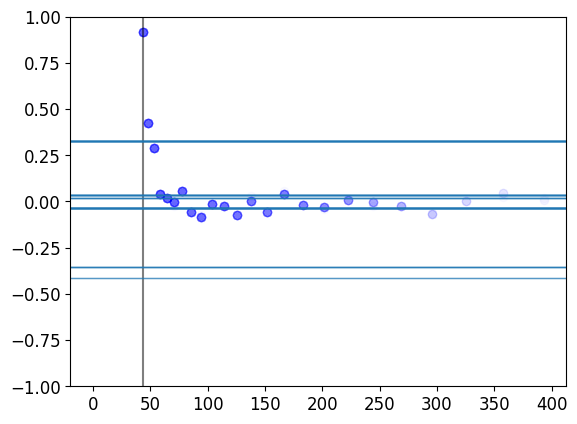

In [12]:
[plt.scatter(iso_exp15[i].sma,iso_exp15[i].intens,c='b',alpha=0.02) for i in range(42)]
plt.axvline(x=iso_norm15[0].sma[-1],c="k", alpha=0.5)
[plt.axhline(y=masked_sky15[i],lw=1,alpha=0.5)for i in range(42)]
plt.ylim((-1,1));

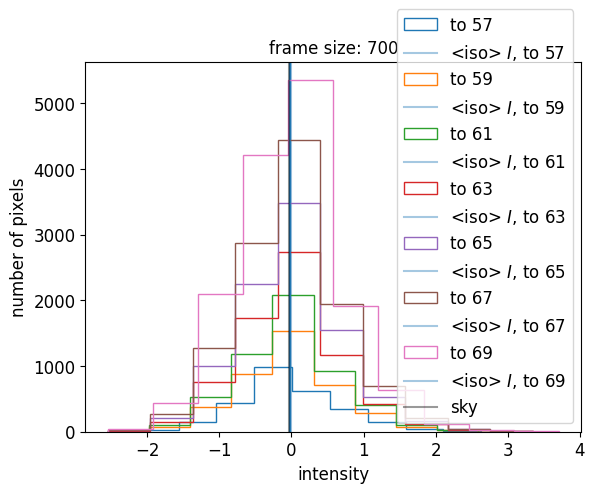

In [58]:
# choose a frame size
i = -1
iso_n = iso_norm15[i]
iso_f = iso_exp15[i]
for isoth in range(57,len(iso_f.sma),2):
    ff = np.concatenate([iso_f[i].sample.values[2] for i in range(50,isoth)])
    plt.hist(ff,histtype="step",label=f"to {isoth}")
    meanI = iso_f.intens[50:isoth].mean()
    plt.axvline(x=ff.mean(),label='<iso> $I$, to '+str(isoth),alpha=0.4)
plt.axvline(x=masked_sky15[i],label='sky',c='k',alpha=0.4)
plt.title(f"frame size: {size[i]}")
plt.xlabel("intensity")
plt.ylabel("number of pixels")
plt.legend();

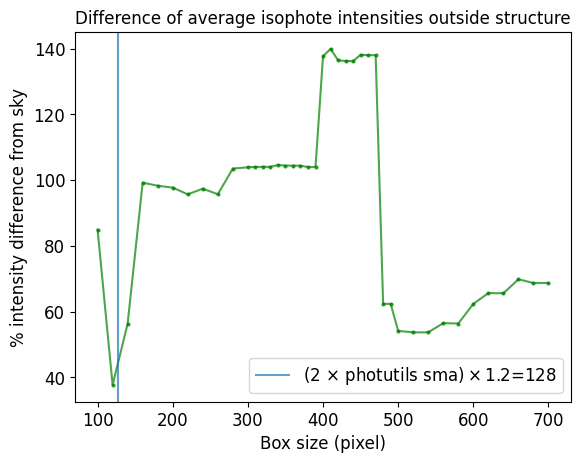

In [95]:
mean_i = [iso_exp15[i].intens[50:].mean() for i in range(len(size))]
dif = np.abs((mean_i-masked_sky15)/(masked_sky15))*100
rphot = iso_norm15[10].sma[-1]*1.2*2
plt.plot(size,dif,marker='o',c='g',alpha=0.7,markersize=2)
plt.axvline(x=rphot,label=f"(2 $\\times$ photutils sma$)\\times$1.2={rphot:.0f}",alpha=0.7)
plt.xlabel("Box size (pixel)")
plt.ylabel("% intensity difference from sky")
plt.title("Difference of average isophote intensities outside structure")
plt.legend();

In [251]:
ff = np.concatenate([iso_f[i].sample.values[2] for i in range(50,56)])
(ff.mean()-np.mean([iso_f[i].intens for i in range(50,56)]))/ff.mean()*100

58.511633361403796

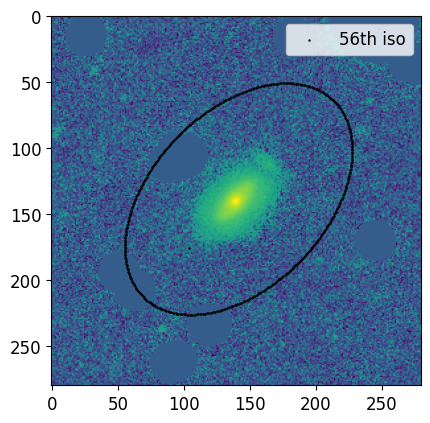

In [219]:
x,y = iso_f[56].sample.coordinates()
fig,ax = plt.subplots()
ax.imshow(ims15[i],norm='symlog')
ax.scatter(x,y,c="k",s=0.5,label='56th iso')
ax.legend();


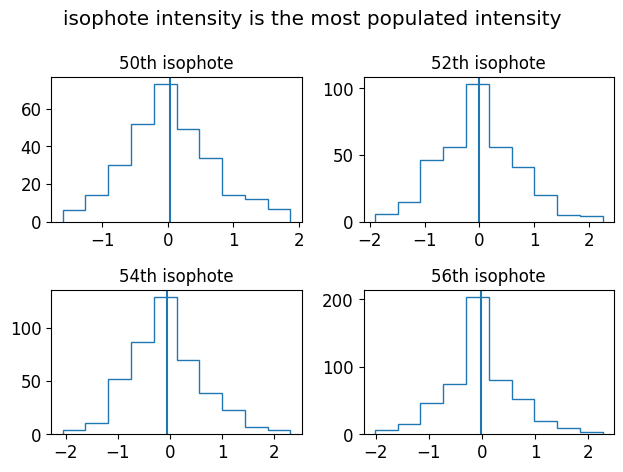

In [105]:
fig,ax = plt.subplots(2,2)
ax = ax.ravel()
for i,j in zip(range(50,len(iso_f.sma),2),range(len(ax))):
    ax[j].hist(iso_f[i].sample.values[2],histtype='step')
    ax[j].axvline(x=iso_f[i].intens)
    ax[j].set_title(f"{i}th isophote")
fig.suptitle("isophote intensity is the most populated intensity")
fig.tight_layout();

In [ ]:
m